# Object Removal and Impainting using Generative Adverserial Network
## Project by: Anna Wang, Jimmy Yang and Phillip Chen


# Abstract
## TO DO 

# 1 Environment

run the following cells to set up your environment

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2 Importing Dataset

Our dataset comes from Hugging Face Dataset cats_vs_dogs: https://huggingface.co/datasets/microsoft/cats_vs_dogs

Run the cell below to set up datasets in your environment, further instructions for how to import the dataset are included in the README

In [ ]:
# uncomment code blocks below when needed
# !huggingface-cli login
# !pip install datasets

### 2.1 Importing Cats vs. Dogs Dataset

In [8]:
from datasets import load_dataset

ds = load_dataset("microsoft/cats_vs_dogs")

print(ds['train'])

Dataset({
    features: ['image', 'labels'],
    num_rows: 23410
})


### 2.2 Filtering Dataset by Cats and Dogs

In [4]:
# filtering data by cats and dogs
data = ds['train']
dogs = data.filter(lambda isDog: isDog['labels'] == 1)
cats = data.filter(lambda isDog: isDog['labels'] == 0)
print("Dataset size: " + str(len(data)))

print("Total dataset size:", len(data))
print("Dogs:", len(dogs))
print("Cats:", len(cats))

Dataset size: 23410
Total dataset size: 23410
Dogs: 11669
Cats: 11741


### 2.3 Splitting each class into training and test sets

Dog Train Set: 9335
Dog Test Set: 2334
Cat Train Set: 9392
Cat Test Set: 2349


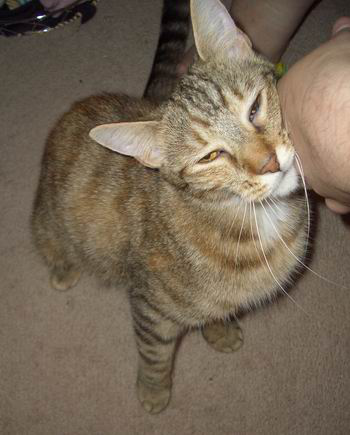

In [9]:
# Split each class into train/test
dog_split = dogs.train_test_split(test_size=0.2, seed=200)
cat_split = cats.train_test_split(test_size=0.2, seed=200)

# Get subsets
train_dog = dog_split['train']['image']
test_dog = dog_split['test']['image']
train_cat = cat_split['train']['image']
test_cat = cat_split['test']['image']

print("Dog Train Set: " + str(len(train_dog)))
print("Dog Test Set: " + str(len(test_dog)))

print("Cat Train Set: " + str(len(train_cat)))
print("Cat Test Set: " + str(len(test_cat)))
train_cat[1]

# 3 Creating Data Loaders

### 3.1 Transformations TO DO FIX WRITING

We experimented with several transformations, including different versions of crops and normalizations. The model performance was best when we simply converted pixel values into [0, 1] range and resized the entire image to 256x256 rather than taking a crop of the image.

In [ ]:
transforms = v2.Compose([
    v2.ToTensor(),
    v2.Resize(size=(64, 64))
])

### 3.2 Masks

In [ ]:
hole_size = 20

def create_masks(N, im_h, im_w):
    x = int((im_w - hole_size) / 2.0)
    y = int((im_h - hole_size) / 2.0)
    mask = torch.zeros((1, im_h, im_w))
    mask[0, y : y + hole_size, x : x + hole_size] = 1
    masks = mask.repeat_interleave(N, dim=0)
    # masks = torch.cat(masks, dim=0)
    return masks.unsqueeze(1)

### 3.2 Creating Cat Dataset Definition

The following class defines our Cat Dataset 

In [20]:
class CatDataset(Dataset):
    def __init__(self, all_imgs, transforms=None) -> None:
        super().__init__()
        self.transforms = transforms
        self.all_imgs = all_imgs


    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, index):
        image = self.all_imgs[index]

        transformed_img = self.transforms(image) if self.transforms else image
        # transformed_img = transformed_img[0]

        # create deep copy of image for transformation
        ground_truth_image = deepcopy(transformed_img)

        # # change center depending on where to randomize
        mask = create_masks(1, 64, 64)[0]
        transformed_img = (1 - mask) * transformed_img
        # transformed_img[:, 10:20, 10:20] = torch.rand((3, 10, 10))
        #transformed_img[:, 96:160, 96:160] = torch.rand((3, 64, 64))

        return transformed_img, ground_truth_image

In [23]:
# Split the dataset
train_test_split = cats_ds['train'].train_test_split(test_size=0.2, seed=42)
test_val_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)
train_dataset = train_test_split['train']['image']
val_dataset = test_val_split['train']['image']
test_dataset = test_val_split['test']['image']

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

transforms = v2.Compose([
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    v2.Resize(size=(64, 64))
])

transformed_train_dataset = CatDataset(train_dataset, transforms=transforms)
transformed_val_dataset = CatDataset(val_dataset, transforms=transforms)
transformed_test_dataset = CatDataset(test_dataset, transforms=transforms)

NameError: name 'cats_ds' is not defined

# Masks

In [21]:
hole_size = 20

def create_masks(N, im_h, im_w):
    x = int((im_w - hole_size) / 2.0)
    y = int((im_h - hole_size) / 2.0)
    mask = torch.zeros((1, im_h, im_w))
    mask[0, y : y + hole_size, x : x + hole_size] = 1
    masks = mask.repeat_interleave(N, dim=0)
    # masks = torch.cat(masks, dim=0)
    return masks.unsqueeze(1)

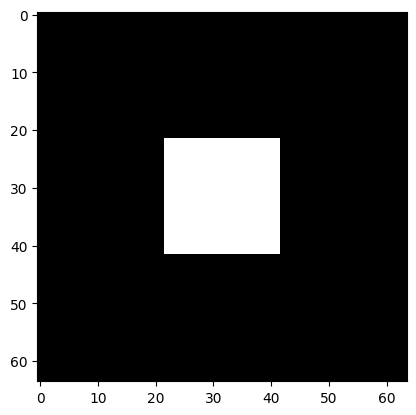

In [17]:
# Display Mask
plt.imshow(create_masks(1, 64, 64)[0][0], cmap='gray')

In [ ]:
# Display image with mask

train = train_cat[1]
# NOTE TODO: EDIT TO USE OUR DATALOADER IMAGE THING
imshow((1 - create_masks(1, 32, 32)[0][0]) * train[1000][0])